In [5]:
# ============================================================
# === Utils: DRY helpers (plotting, EDA, cleaning, modeling)==
# ============================================================
from __future__ import annotations
import re
from typing import List, Tuple, Dict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def load_data(csv_path: str) -> pd.DataFrame:
    """Load the survey CSV into a DataFrame"""
    return pd.read_csv(csv_path, low_memory=False)


def detect_salary_column(df: pd.DataFrame) -> str:
    """Detect the correct salary column across survey vintages"""
    if "ConvertedCompYearly" in df.columns:
        return "ConvertedCompYearly"
    if "CompTotal" in df.columns:
        return "CompTotal"
    raise KeyError("Salary column not found. Expected 'ConvertedCompYearly' or 'CompTotal'.")


# ---------- Cleaning helpers ----------

def parse_years_code_pro(x: object) -> float:
    """Convert YearsCodePro strings to numeric years.

    'Less than 1 year'→0.5, 'More than 50 years'→51.0, else first numeric token, NaN if none.
    """
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    if s.startswith("less than"):
        return 0.5
    if s.startswith("more than 50"):
        return 51.0
    m = re.search(r"\d+(?:\.\d+)?", s)
    return float(m.group()) if m else np.nan


def normalize_edlevel(x: object) -> str:
    """Bucketize education level into {Bachelors, Masters, PostGrad, Other}."""
    s = "" if pd.isna(x) else str(x)
    if "Bachelor" in s: return "Bachelors"
    if "Master" in s:   return "Masters"
    if "Professional" in s or "Doctoral" in s: return "PostGrad"
    return "Other"


def prepare_data(df_raw: pd.DataFrame, salary_col: str) -> pd.DataFrame:
    """Create `Salary`, drop invalid, trim outliers, keep robust columns, normalize fields.

    Steps
    -----
    - Salary numeric → drop missing / non-positive
    - Trim to 1st–99th percentile to reduce extreme outliers
    - Keep: Country, EdLevel, YearsCodePro, Employment, DevType, JobSat (when present)
    - Normalize YearsCodePro & EdLevel; map JobSat to ordinal (JobSatNum)
    """
    df = df_raw.copy()
    df["Salary"] = pd.to_numeric(df[salary_col], errors="coerce")
    df = df[df["Salary"].notna() & (df["Salary"] > 0)]

    q01, q99 = df["Salary"].quantile([0.01, 0.99])
    df = df[(df["Salary"] >= q01) & (df["Salary"] <= q99)]

    keep_cols = [c for c in ["Country","EdLevel","YearsCodePro","Employment","DevType", "Age","JobSat"]
                 if c in df.columns]
    df = df[keep_cols + ["Salary"]].copy()

    if "YearsCodePro" in df.columns:
        df["YearsCodePro"] = df["YearsCodePro"].apply(parse_years_code_pro)

    if "EdLevel" in df.columns:
        df["EdLevel"] = df["EdLevel"].apply(normalize_edlevel)

    if "JobSat" in df.columns:
        job_map = {"Very satisfied":4,"Slightly satisfied":3,"Neither satisfied nor dissatisfied":2,
                   "Slightly dissatisfied":1,"Very dissatisfied":0}
        df["JobSatNum"] = df["JobSat"].map(job_map)

    return df


# ---------- EDA helpers ----------

def median_salary_by_country(df: pd.DataFrame, min_n: int = 50, top_k: int = 10) -> pd.Series:
    """Median salary per country; filter by `min_n`; return top-k by median."""
    if "Country" not in df.columns:
        return pd.Series(dtype=float)
    grp = df.groupby("Country")["Salary"]
    ms = grp.median()
    counts = grp.size()
    ms = ms[counts >= min_n]
    return ms.sort_values(ascending=False).head(top_k)


def median_salary_by_role(df: pd.DataFrame, top_k: int = 10) -> pd.Series:
    """Median salary per DevType role (`;`-separated); return top-k by median."""
    if "DevType" not in df.columns:
        return pd.Series(dtype=float)
    roles = (df.dropna(subset=["DevType"])
               .assign(DevType=df["DevType"].str.split(";"))
               .explode("DevType")
               .rename(columns={"DevType":"Role"}))
    return roles.groupby("Role")["Salary"].median().sort_values(ascending=False).head(top_k)


def format_currency_axis(ax: plt.Axes) -> None:
    """Format x-axis as compact USD labels (k, M)."""
    def _fmt(x, _pos):
        if x >= 1_000_000: return f"${x/1_000_000:.1f}M"
        if x >= 1_000:     return f"${x/1_000:.0f}k"
        return f"${x:,.0f}"
    ax.xaxis.set_major_formatter(mtick.FuncFormatter(_fmt))


def plot_barh_medians(series: pd.Series, title: str, xlabel: str, ylabel: str) -> None:
    """Generic horizontal bar plot for median series (index=labels)."""
    if series.empty:
        print("[No data available]")
        return
    s = series.sort_values()
    fig, ax = plt.subplots(figsize=(10,6))
    ax.barh(s.index, s.values)
    format_currency_axis(ax)
    for i, v in enumerate(s.values):
        ax.text(v, i, f"${v:,.0f}", va="center", ha="left", fontsize=9)
    ax.set_title(title, fontweight="bold")
    ax.set_xlabel(xlabel); ax.set_ylabel(ylabel)
    fig.tight_layout(); plt.show()


# ---------- Modeling helpers ----------

def build_feature_matrix(df: pd.DataFrame, top_k_roles: int = 8) -> Tuple[pd.DataFrame, pd.Series, List[str]]:
    """Create X (features) and y (target) with optional DevType binary flags.

    Returns
    -------
    X : pd.DataFrame
    y : pd.Series
    role_list : list of role names used for binary flags
    """
    y = df["Salary"].astype(float)
    base_cat = [c for c in ["Country","EdLevel","Employment"] if c in df.columns]
    base_num = [c for c in ["YearsCodePro","JobSatNum"] if c in df.columns]
    X = df[base_cat + base_num].copy()

    role_list: List[str] = []
    if "DevType" in df.columns and df["DevType"].notna().any():
        roles_long = (df.dropna(subset=["DevType"])
                        .assign(DevType=df["DevType"].str.split(";"))
                        .explode("DevType"))
        role_list = list(roles_long["DevType"].value_counts().head(top_k_roles).index)
        for r in role_list:
            X[f"role_{r}"] = df["DevType"].fillna("").str.contains(r, regex=False).astype(int)

    X = X.loc[:, X.notna().any(axis=0)]
    return X, y, role_list


def safe_one_hot_encoder() -> OneHotEncoder:
    """Create cross-version compatible OneHotEncoder (sparse_output vs sparse)."""
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)


def build_pipeline(X: pd.DataFrame) -> Tuple[Pipeline, List[str], List[str]]:
    """Preprocessing + LinearRegression pipeline derived from X dtypes."""
    num_feats = [c for c in X.columns if X[c].dtype.kind in "fc"]
    cat_feats = [c for c in X.columns if c not in num_feats]

    numeric = SimpleImputer(strategy="median")
    categor = Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                        ("enc", safe_one_hot_encoder())]) if len(cat_feats) else "drop"

    prep = ColumnTransformer([("num", numeric, num_feats),
                              ("cat", categor, cat_feats)], remainder="drop")
    model = Pipeline([("prep", prep), ("lr", LinearRegression())])
    return model, num_feats, cat_feats


def evaluate_regression(y_true: pd.Series, y_pred: np.ndarray) -> Dict[str, float]:
    """Return MAE, RMSE, R² for regression evaluation."""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}


def plot_regression_diagnostics(y_true: pd.Series, y_pred: np.ndarray) -> Dict[str, float]:
    """Plot: Actual vs Predicted, Residuals histogram, Residuals vs Predicted. Return residual stats."""
    resid = y_true - y_pred

    # 1) Actual vs Predicted
    fig, ax = plt.subplots(figsize=(7,6))
    ax.scatter(y_true, y_pred, alpha=0.3)
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    ax.plot(lims, lims, ls="--")
    ax.set_xlim(lims); ax.set_ylim(lims)
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel("Actual Salary"); ax.set_ylabel("Predicted Salary")
    ax.set_title("Linear Regression: Actual vs Predicted")
    fig.tight_layout(); plt.show()

    # 2) Residuals histogram
    fig, ax = plt.subplots(figsize=(8,4))
    ax.hist(resid, bins=60)
    ax.set_title("Residuals (Actual - Predicted) — Linear Regression")
    ax.set_xlabel("Residual"); ax.set_ylabel("Count")
    fig.tight_layout(); plt.show()

    # 3) Residuals vs Predicted
    fig, ax = plt.subplots(figsize=(7,4))
    ax.scatter(y_pred, resid, alpha=0.3)
    ax.axhline(0, ls="--")
    ax.set_xlabel("Predicted"); ax.set_ylabel("Residual")
    ax.set_title("Residuals vs Predicted — Linear Regression")
    fig.tight_layout(); plt.show()

    return {
        "resid_mean": float(np.mean(resid)),
        "resid_std": float(np.std(resid)),
        "resid_median": float(np.median(resid)),
    }

In [2]:
# ============================================================
# === [CRISP-DM] Business Understanding ======================
# ============================================================
BUSINESS_MD = """
# Business Understanding
Goal: Provide a transparent baseline for estimating developer salary (USD) using a compact,
robust feature set across Stack Overflow survey vintages, and highlight salary patterns by
country and role.

Key Questions:
- Which countries/roles (with sufficient responses) exhibit higher median salaries?
- Given a few attributes (country, education, experience, role signals), how well can a simple
  linear model explain salary variance?
"""
print(BUSINESS_MD)


# Business Understanding
Goal: Provide a transparent baseline for estimating developer salary (USD) using a compact,
robust feature set across Stack Overflow survey vintages, and highlight salary patterns by
country and role.

Key Questions:
- Which countries/roles (with sufficient responses) exhibit higher median salaries?
- Given a few attributes (country, education, experience, role signals), how well can a simple
  linear model explain salary variance?



In [6]:
# ============================================================
# === [CRISP-DM] Data Understanding: Load ====================
# ============================================================
CSV_PATH = "/content/survey_results_public.csv"  # change if needed
df_raw = load_data(CSV_PATH)
print(f"✅ Loaded: {CSV_PATH} | shape: {df_raw.shape}")

✅ Loaded: /content/survey_results_public.csv | shape: (65437, 114)


In [7]:
# ============================================================
# === [CRISP-DM] Detect Salary Column ========================
# ============================================================
salary_col = detect_salary_column(df_raw)
print("Using salary column:", salary_col)

Using salary column: ConvertedCompYearly


In [8]:
# ============================================================
# === [CRISP-DM] Prepare Data ================================
# ============================================================
df = prepare_data(df_raw, salary_col)
print("Rows after cleaning:", len(df))

Rows after cleaning: 22965


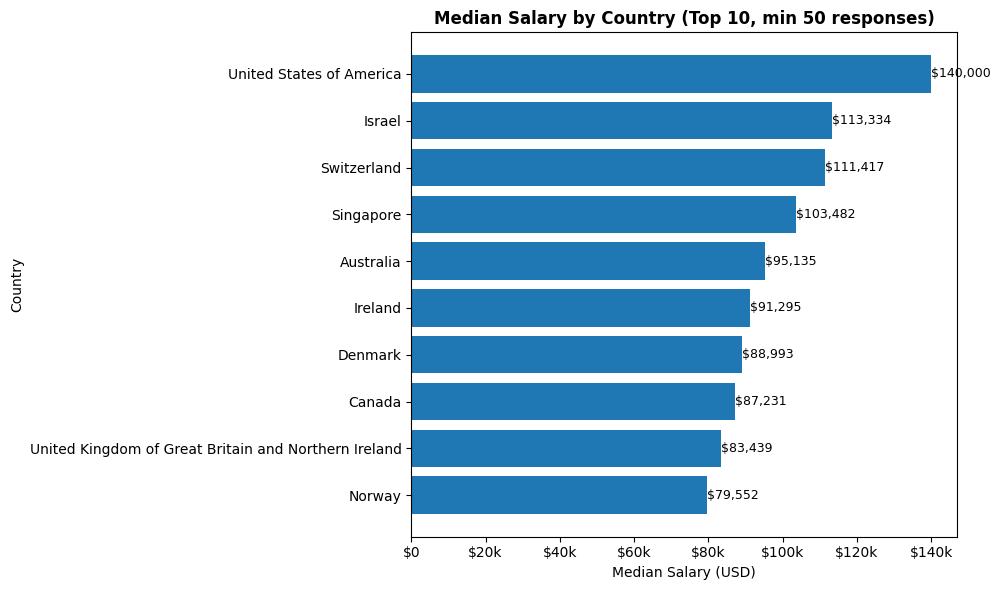

In [9]:
# ============================================================
# === [CRISP-DM] EDA: Median Salary by Country ===============
# ============================================================
ms = median_salary_by_country(df, min_n=50, top_k=10)
plot_barh_medians(ms, "Median Salary by Country (Top 10, min 50 responses)", "Median Salary (USD)", "Country")

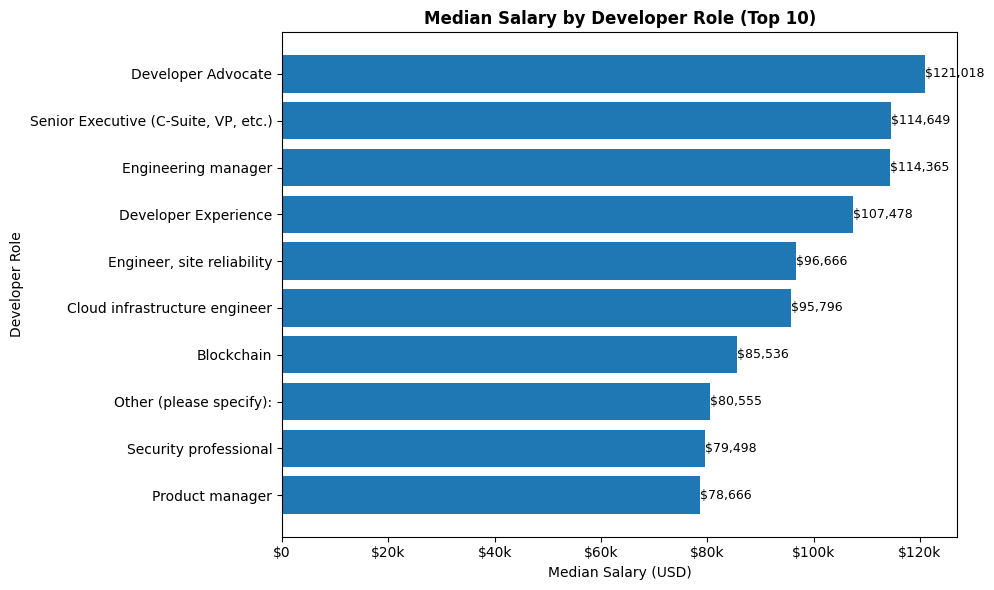

In [10]:
# ============================================================
# === [CRISP-DM] EDA: Median Salary by Developer Role ========
# ============================================================
role_medians = median_salary_by_role(df, top_k=10)
plot_barh_medians(role_medians, "Median Salary by Developer Role (Top 10)", "Median Salary (USD)", "Developer Role")

In [11]:
# ============================================================
# === [CRISP-DM] Data Modeling ===============================
# ============================================================
X, y, role_list = build_feature_matrix(df, top_k_roles=8)
print("Feature columns:", list(X.columns))
print("X shape:", X.shape, "| y:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model, num_feats, cat_feats = build_pipeline(X)
model.fit(X_train, y_train)
print("✅ Model trained.")

Feature columns: ['Country', 'EdLevel', 'Employment', 'YearsCodePro', 'role_Developer, full-stack', 'role_Developer, back-end', 'role_Developer, front-end', 'role_Developer, desktop or enterprise applications', 'role_Developer, mobile', 'role_Developer, embedded applications or devices', 'role_Other (please specify):', 'role_Data engineer']
X shape: (22965, 12) | y: (22965,)
✅ Model trained.


Linear Regression → MAE: 27,881 | RMSE: 41,439 | R²: 0.544


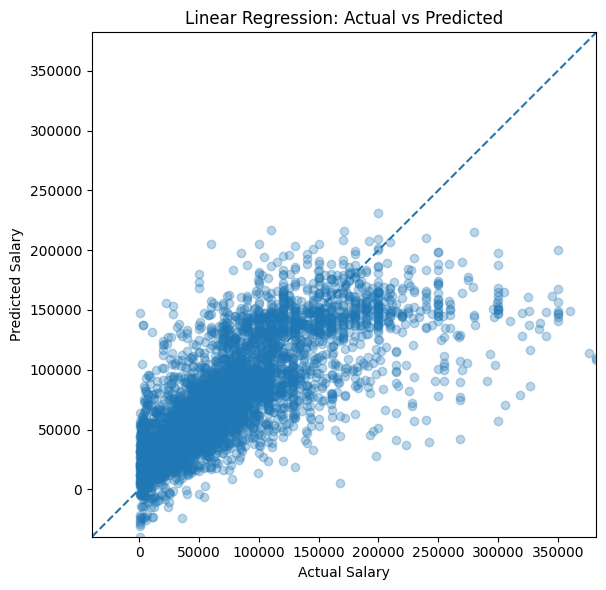

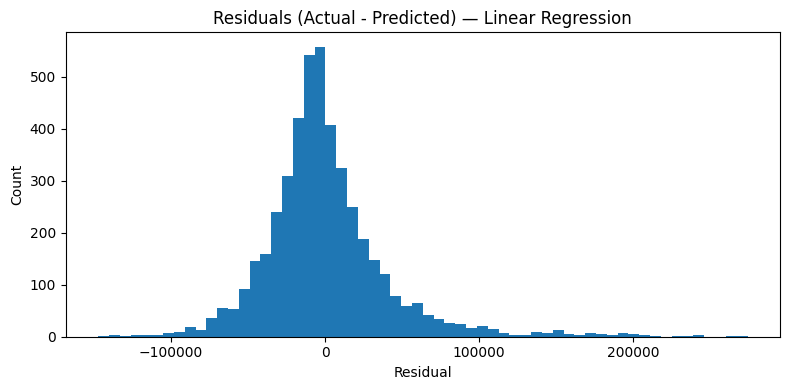

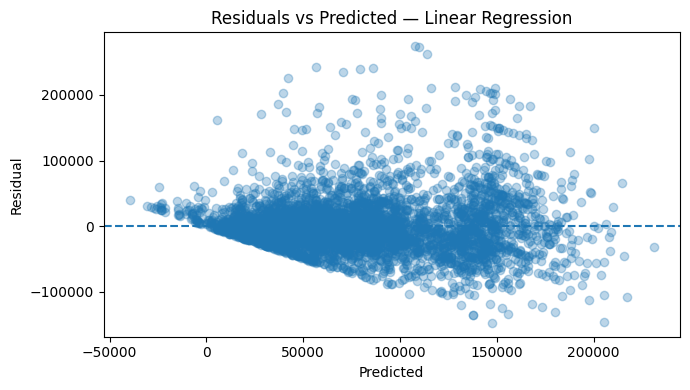

Residual stats: {'resid_mean': '398', 'resid_std': '41,437', 'resid_median': '-4,908'}


In [12]:
# ============================================================
# === [CRISP-DM] Evaluate the Results ========================
# ============================================================
pred = model.predict(X_test)
metrics = evaluate_regression(y_test, pred)
print(f"Linear Regression → MAE: {metrics['MAE']:,.0f} | RMSE: {metrics['RMSE']:,.0f} | R²: {metrics['R2']:.3f}")

resid_stats = plot_regression_diagnostics(y_test, pred)
print("Residual stats:", {k: f"{v:,.0f}" if "resid" in k else v for k, v in resid_stats.items()})